# Stars vs. Galaxies in Machine Learning
#### Candice Stauffer
#### Data_Sci 423, Spring 2020
#### Professor Aggelos Katsaggelos 
#### Final Project

With the advent of technological advancements in the design and implementation of telescopes, astronomers need more sophisticated tools to analyze the immense amounts of data. Machine learning has allowed astronomers to improve on the classification of objects observed in the sky. Algorithms developed through machine learning allow astronomers to dis-
sect up to petabytes of data, in order to learn about the vast mysteries of
the universe.

In this project, data has been taken from a Sloan Digital Sky Survey (SDSS) [Sloan Digital Sky Survey](http://www.sdss.org)  released and processed through machine learning algorithms to classify stars from galaxies. The SDSS is an international collaboration which uses a 2.5-m wide-angle optical telescope at the Apache Point Observatory in New Mexico, US. With this telescope, the SDSS creates a multi-spectral imaging and spectroscopic redshift survey which has so far been able to observe over
1 billion objects.

To seperate the stars from galaxies with this SDSS dataset, I followed this machine learning workflow:


Part 1. Obtain, Examine, and Prepare Data

Part 2. Build Model

Part 3. Evaluate Model

Part 4. Optimize Model

Part 5. Model Predictions on New Data

# Part 0
## Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from autograd import grad
from autograd import hessian
from sklearn.model_selection import train_test_split
import scipy
import math
import collections 
%matplotlib inline
plt.style.use('default')

# Part 1
## Obtain, Examine, and Prepare Data

Here, sources with known labels include stars and galaxies that have been confirmed with spectroscopic observations. Machine learning is needed because there are $\gg 10^8$ sources with photometric observations in SDSS, and only $4 \times 10^6$ sources with spectroscopic observations. This will allow me to use spectroscopic observations as a model for the entire data set entire data set. The features include each $r$-band magnitude measurement made by SDSS. This will yield 8 features (though 454 properties are listed by SDSS)  which I have chosen to be most important in seperating stars from galaxies. The features I have chosen include 'psfMag_r', 'fiberMag_r', 'fiber2Mag_r', 'petroMag_r', 'deVMag_r', 'expMag_r', 'modelMag_r', 'cModelMag_r', and I also include a 9th column, 'class', which corresponds to the labels, 'STAR' or 'GALAXY'.

I obtain the training set by running the following query on the SDSS Database (http://skyserver.sdss.org/dr12/en/tools/search/sql.aspx):

    SELECT TOP 20000
    p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
    p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
    s.class
    FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
    WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO'
    ORDER BY p.objid ASC

I have created pair plots to visualize this data and determine which of the features I've selected is probably the most important. 

In [2]:
sdss_df = pd.read_hdf("sdss_training_set.h5")

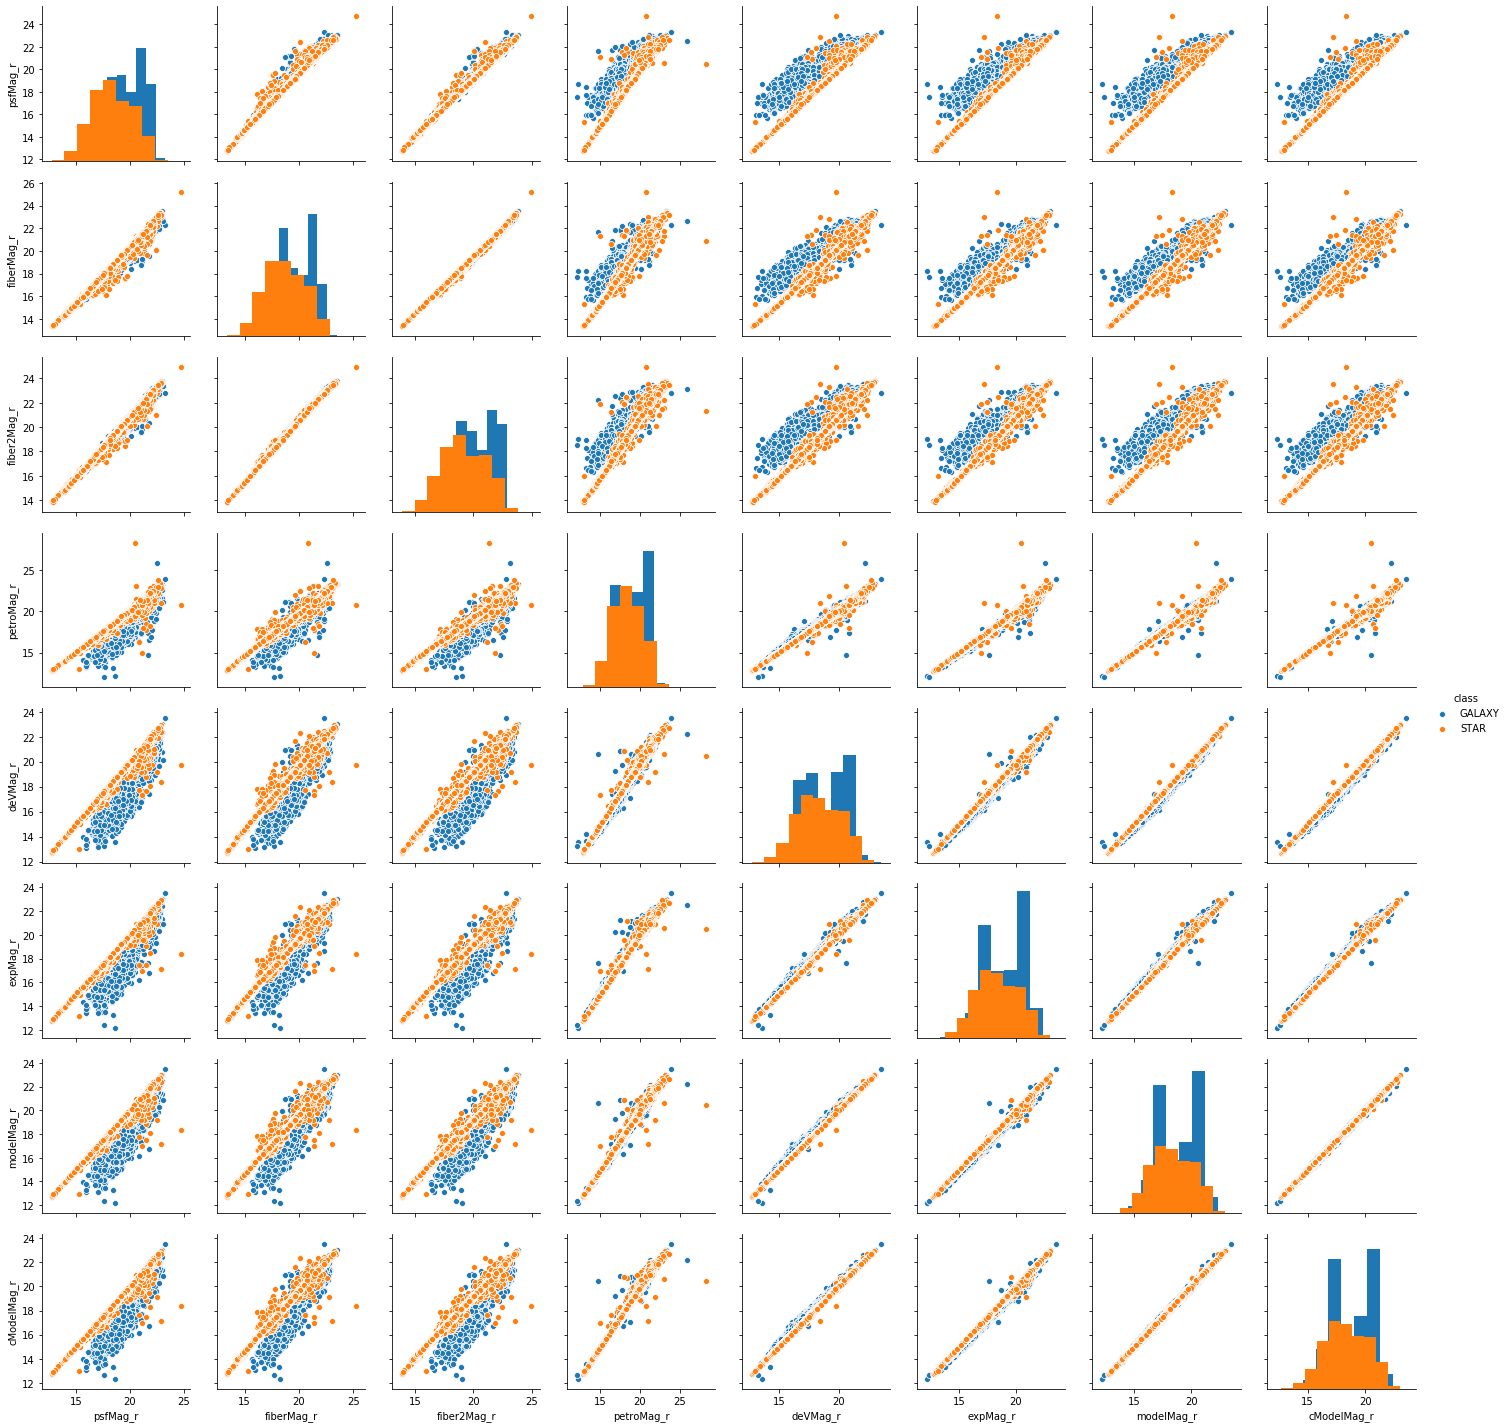

In [3]:
sns.pairplot(sdss_df, hue = 'class', diag_kind = 'hist')

By observing the data, it appears that the most important for separating stars and galaxies will most likely be either expMag, cModelMag, or modelMag, because these are the features that have significantly different distributions for stars and galaxies. 

In [3]:
rs = 1851
sdss_arr = sdss_df.values

x = sdss_arr[:, :-1]
y = sdss_arr[:, -1]

In [44]:
#Greater number of samples = greater accuracy 
#Less samples = quicker!

sample = 300
train_X, test_X, train_y, test_y = train_test_split(x[0:sample], y[0:sample], test_size=0.3, random_state=rs)

90


# Part 2
## Building the Model

To build my model I will use a two-class classification, where the two classes are of course stars and galaxies. 

In [10]:
def fit(X, y):
    X_train = X
    y_train = y
    return X_train[0:sample], y_train[0:sample]

X_train, y_train = fit(sdss_arr[:, :-1],sdss_arr[:, -1])

#find Euclidian difference
def distance(X1, X2):
    distance = scipy.spatial.distance.euclidean(X1, X2)
    
def predict(X_test,k):
    final_output = []
    for i in range(len(X_test)):
        d = []
        votes = []
        
        for j in range(len(X_train)):
            dist = scipy.spatial.distance.euclidean(X_train[j] , X_test[i])
            d.append([dist, j])
        d.sort()
        
        d = d[0:k]
        for d, j in d:
            votes.append(y_train[j])
        ans = collections.Counter(votes).most_common(1)[0][0]
        final_output.append(ans)

    return final_output
    
def score(X_test, y_test,k):
    predictions = predict(X_test,k)
    return (predictions == y_test).sum()/ len(y_test)

In [45]:
fit(train_X, train_y) 
prediction = predict(test_X,25) #test x, k 
for i in prediction:
    print(i, end= ' ')

GALAXY GALAXY GALAXY GALAXY GALAXY GALAXY STAR GALAXY GALAXY STAR GALAXY GALAXY GALAXY GALAXY STAR STAR GALAXY STAR GALAXY GALAXY GALAXY STAR GALAXY GALAXY GALAXY GALAXY GALAXY GALAXY GALAXY GALAXY STAR GALAXY STAR GALAXY GALAXY GALAXY GALAXY GALAXY STAR GALAXY GALAXY GALAXY GALAXY GALAXY GALAXY STAR STAR GALAXY GALAXY STAR STAR GALAXY GALAXY STAR STAR GALAXY GALAXY GALAXY GALAXY GALAXY GALAXY GALAXY STAR GALAXY GALAXY STAR STAR GALAXY GALAXY GALAXY GALAXY STAR GALAXY GALAXY STAR GALAXY GALAXY GALAXY GALAXY GALAXY GALAXY STAR GALAXY GALAXY GALAXY GALAXY GALAXY GALAXY STAR STAR 

# Part 3
## Evaluating the Model

To evaluate the performance of the model I have established a baseline that I would like to exceed with the goal to improve the accuracy. 

In the case that the model does not improve upon the baseline, then to accomplish the desired goal, I would return to choose different features to analyze. 

The SDSS photometric pipeline uses a simple parametric model to classify sources as either stars or galaxies. Here, I adopted this SDSS photometric classifier as my baseline.

The SDSS photometric classifier uses a single hard cut to separate stars and galaxies in imaging data: 𝚙𝚜𝚏𝙼𝚊𝚐𝚛−𝚌𝙼𝚘𝚍𝚎𝚕𝙼𝚊𝚐𝚛>0.145 (https://www.sdss.org/dr12/algorithms/classify/#photo_class) 

Sources that satisfy this criteria are considered galaxies. 

In [8]:
k =20

In [46]:
new_trainy = np.zeros(len(train_y)) 

for i in range(0,len(train_y)):
    if train_y[i] == 'STAR':
        new_trainy[i]=1
    else:
        new_trainy[i]=0 

mask = train_X[:, 0] - train_X[:,-1] > 0.145
y_pred = new_trainy.copy()
y_pred[:] = 1
y_pred[mask] = 0

score = np.sum(new_trainy)/len(y_pred) 
print ('baseline =',score)

baseline = 0.3523809523809524


In [10]:
##Which predictions match with the test
# prediction == test_y
scores = []
for i in range(0,8):
    scores.append(score(test_X[:,i][0:sample],test_y[0:sample],k))
    labels = ['psfMag_r', 'fiberMag_r', 'fiber2Mag_r', 'petroMag_r', 'deVMag_r', 'expMag_r', 'modelMag_r','cModelMag_r']

for i in range(0,len(scores)): 
    print (labels[i],'=',scores[i])

psfMag_r = 0.5666666666666667
fiberMag_r = 0.5555555555555556
fiber2Mag_r = 0.6666666666666666
petroMag_r = 0.35555555555555557
deVMag_r = 0.3333333333333333
expMag_r = 0.3888888888888889
modelMag_r = 0.3333333333333333
cModelMag_r = 0.3333333333333333


The values above demonstrate the importance of each feature I've chosen. Each value presents the accuracy score. The feature with the greatest accuracy will contribute the most to the overall accuracy of the model.



In [11]:
max = scores.index(np.amax(scores)) 
print ('Most important feature = ', labels[max])

Most important feature =  fiber2Mag_r


In [12]:
print ('combined score = ', score(test_X[0:sample],test_y[0:sample],k)) 

combined score =  0.9222222222222223


Finally, I have found the overall accuracy or "score" of the model which is also greater than the baseline score I found above. I will not have to go back to find different features to add to my model. 

These scores reflect how well the training set matches the test set or how well the model has correctly predicted a star from a galaxy.  

This accuracy score will improve with a greater amount of training data and also may improve with a different value of "k". Though changing both may have drawbacks.

While increasing the amount of samples will help create a better accuracy score, it will also take longer to run. On an average machine, it's rather impractical to run this program for the entire 20,000 samples I took from SDSS. 

A similar issue occurs with choosing "k", though the issue here is highly data-dependent. Generally, a small value of k means that noise will have a higher influence on the result, however a larger value will also be computationally expensive.

The K-means algorithm divides a set of 𝑁 samples 𝑋 into 𝐾 disjoint clusters 𝐶, each described by the mean of the samples in the cluster. The means are called the cluster “centroids”. The K-means algorithm aims to choose centroids that minimize the "within-cluster sum" of squared criterion. 

In the following section, I optimized my model by finding the value of "k" that gave me the best accuracy score and still allowed me to run my model within a reasonable amount of time. 

# Part 4
## Optimizing the Model

Here, I will rerun my model with different values of "k" to determine which gives the most accurate score. 

In [27]:
best_score = []
k_ = []
for k in range(5,50):
    k_.append(k)
    best_score.append(score(test_X[0:sample],test_y[0:sample],k)) 
    print ('combined score ', '(k =', k,')','=', score(test_X[0:sample],test_y[0:sample],k)) 

combined score  (k = 5 ) = 0.9555555555555556
combined score  (k = 6 ) = 0.9666666666666667
combined score  (k = 7 ) = 0.9333333333333333
combined score  (k = 8 ) = 0.9555555555555556
combined score  (k = 9 ) = 0.9333333333333333
combined score  (k = 10 ) = 0.9777777777777777
combined score  (k = 11 ) = 0.9333333333333333
combined score  (k = 12 ) = 0.9444444444444444
combined score  (k = 13 ) = 0.9444444444444444
combined score  (k = 14 ) = 0.9555555555555556
combined score  (k = 15 ) = 0.9
combined score  (k = 16 ) = 0.9222222222222223
combined score  (k = 17 ) = 0.9222222222222223
combined score  (k = 18 ) = 0.9222222222222223
combined score  (k = 19 ) = 0.9111111111111111
combined score  (k = 20 ) = 0.9222222222222223
combined score  (k = 21 ) = 0.9222222222222223
combined score  (k = 22 ) = 0.9222222222222223
combined score  (k = 23 ) = 0.9222222222222223
combined score  (k = 24 ) = 0.9222222222222223
combined score  (k = 25 ) = 0.9222222222222223
combined score  (k = 26 ) = 0.922

In [28]:
bestscore_idx = best_score.index(np.max(best_score)) 
print ('Highest Accuracy Occurs at K = ', k_[bestscore_idx])

Highest Accuracy Occurs at K =  10


Since the highest model accuracy occurs when k = 10, I used k = 10 for my model predictions in part 5. 

# Part 5
## Model Predictions for New Data

Finally, I used a test set with k=10 to make predictions about which data are stars and which are galaxies. 

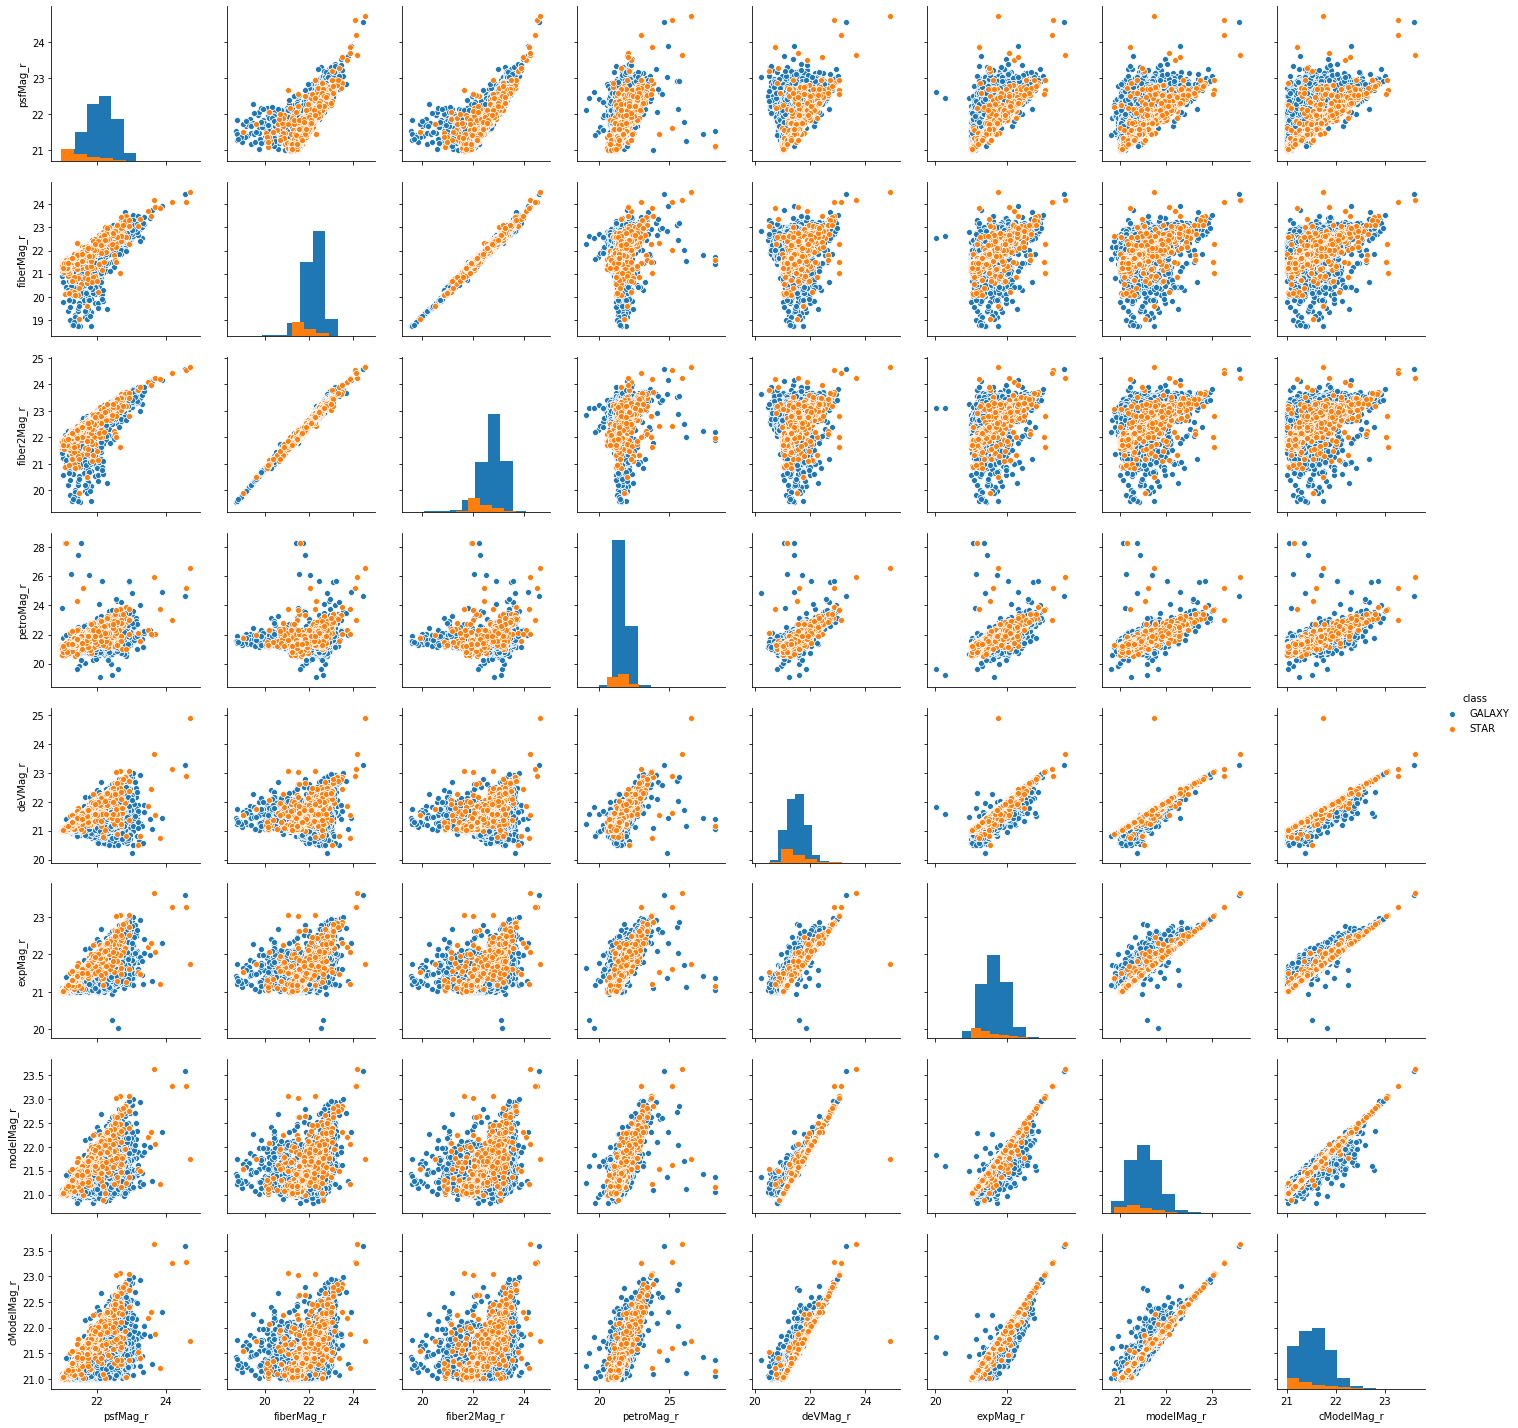

In [5]:
new_data_df = pd.read_hdf("blind_test_set.h5")
sns.pairplot(new_data_df, hue = 'class', diag_kind = 'hist')

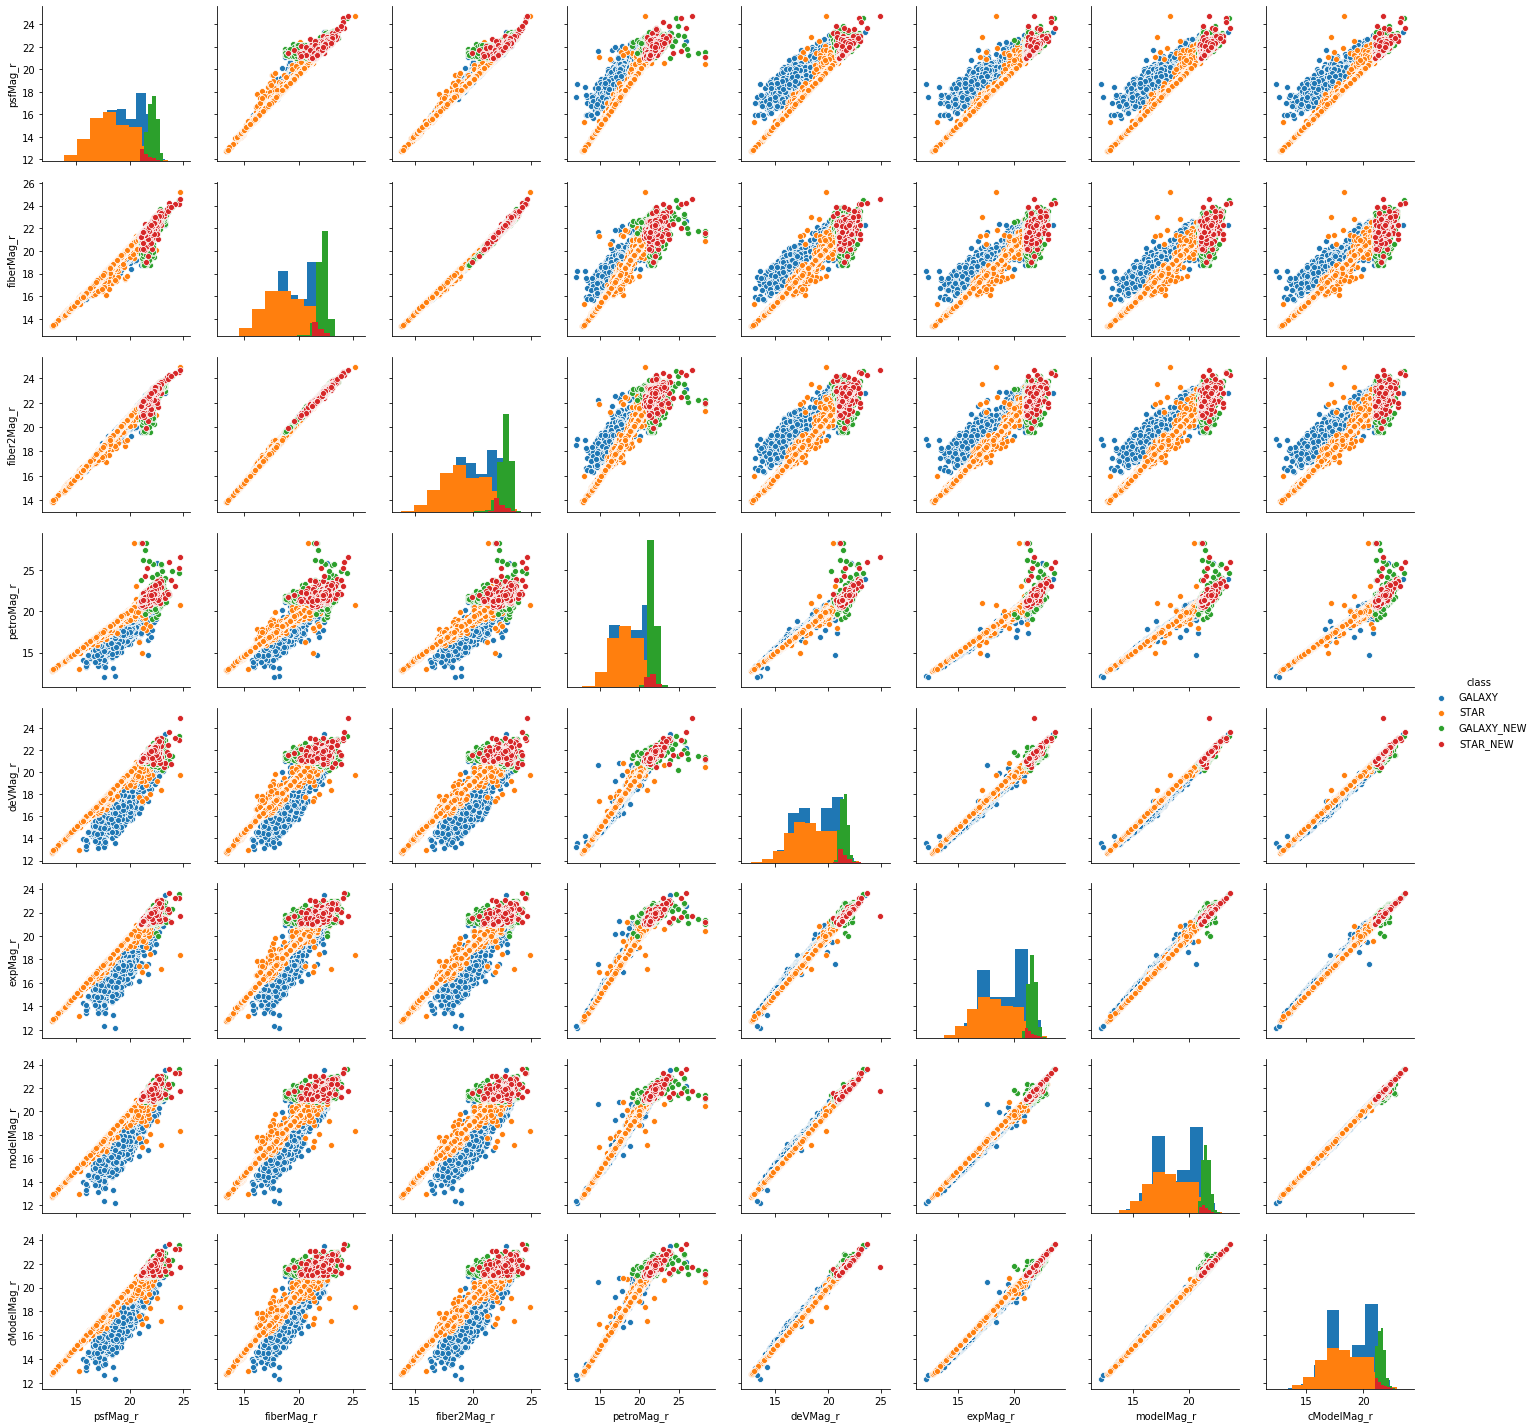

In [40]:
#Here we observe the new test data with old, classified data
all_data = pd.concat([sdss_df, new_data_df], ignore_index=True)
sns.pairplot(all_data, hue = 'class', diag_kind = 'hist')

In [16]:
new_arr = new_data_df.values

x_new = new_arr[:, :-1]
y_new = new_arr[:, -1]

sample = 300
train_X, test_X, train_y, test_y = train_test_split(x_new[0:sample], y_new[0:sample], test_size=0.3, random_state=rs)

In [17]:
new_trainy = np.zeros(len(train_y)) 

for i in range(0,len(train_y)):
    if train_y[i] == 'STAR':
        new_trainy[i]=1
    else:
        new_trainy[i]=0 

mask = train_X[:, 0] - train_X[:,-1] > 0.145
y_pred = new_trainy.copy()
y_pred[:] = 1
y_pred[mask] = 0

score = np.sum(new_trainy)/len(y_pred) 
print ('baseline =',score)

baseline = 0.06190476190476191


In [12]:
##Which predictions match with the test
# prediction == test_y
k =10 #optimized value of k
X_train, y_train = fit(new_arr[:, :-1],new_arr[:, -1])

scores = []
for i in range(0,8):
    scores.append(score(test_X[:,i][0:sample],test_y[0:sample],k))
    labels = ['psfMag_r', 'fiberMag_r', 'fiber2Mag_r', 'petroMag_r', 'deVMag_r', 'expMag_r', 'modelMag_r','cModelMag_r']

for i in range(0,len(scores)): 
    print (labels[i],'=',scores[i])

psfMag_r = 0.9222222222222223
fiberMag_r = 0.9222222222222223
fiber2Mag_r = 0.9222222222222223
petroMag_r = 0.9222222222222223
deVMag_r = 0.9222222222222223
expMag_r = 0.9222222222222223
modelMag_r = 0.9222222222222223
cModelMag_r = 0.9222222222222223


In [13]:
max = scores.index(np.amax(scores)) 
print ('Most important feature = ', labels[max])

Most important feature =  psfMag_r


In [14]:
print ('combined score = ', score(test_X[0:sample],test_y[0:sample],k)) 

combined score =  0.9222222222222223


The resulting accuracy score is as good as the training data (as it cannot be *better*) because the optimized value of "k" is used. This accuracy score is also greater than the baseline which exceeds the critera given by the SDSS.

The k-nearest neighbors model here is therefore sucessful to differentiate stars from galaxies. There are many advantages to this method such as it's simplicity, no need for previous asumptions (i.e. linear regression), the fact that it constantly evolves, and doesn't explicitly build on any other model. However, there are other models have the potential to classify this data more efficiently.

As shown here, k-nearest neighbors is computationally expensive. Only a small sample of stars and galaxies (about 200/20000 selected) were analyzed here. Putting a larger number of data into the model runs a lot more slowly and in addition, begins to struggles to predict the output of new data point. That being said, this model would be great for classifying a small number of stellar objects -- especially for learning/educational purposes-- but will not be useful for very large, up and comming surveys like the Vera Rubin Telescope which is predicted to find thousands of objects per night!

Other models that could be explored for this purpose in the future may include a logistic regression or decision trees (e.g. random forest classifier) that may run a model like this much more quickly and handle a larger amount of data. However, seein